# Data Analysis

### Info
This log is part of the experiment 20139026 at beamline DiProi at Fermi/Trieste (Oct.2017).  

Uses: /src/data_tools.py and /src/fit_tools.py

#### Requires to run '06_data_reduction.ipynb' first!

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
import h5py
import sys

sys.path.insert(0, '../src/')
from data_tools import *
from fit_tools import *

### Load data

Costants and parameters

In [3]:
### CO desorption
runs = [19]
#runs = [21]
## runs = [22]
#runs = [24, 27]
#runs = [28, 29, 30, 31, 32, 33, 34]

### CO oxidation
#runs = [36]
#runs = [37, 38]
#runs = [37]
#runs = [38]
#runs = [39, 40, 41]
#runs = [39]
#runs = [40]
#runs = [41]




t0 = 136.35
c = 299792458 #m/s
#i0_thr = 2e5
i0_thr = 1e5

base_path = '/Volumes/FERMI_2017/DATA/'

discover and sort energy folders

In [4]:
folders = []

print 'Looking up folders for runs...\n'

for run in runs :
    print run
    run_path = 'XAS%03d/' % run
    full_path = base_path + run_path
    folders_tmp,tmp = discover_files(full_path)
    for f in folders_tmp :
        folders.append(run_path+f)

energies = []
e_folders = []

for i in range(len(folders)):
    if folders[i][7:9]=='E2':
        e = float('%s.%s'%(folders[i][8:11],folders[i][12:14]))
        energies.extend([e])
        e_folders.extend([folders[i]])
n_energies = len(energies)
energies_sorted = np.sort(energies)
e_folders_sorted = [x for _,x in sorted(zip(energies,e_folders))]

# print n_energies, energies_sorted, e_folders_sorted


Looking up folders for runs...

19


Load data: For each shots are loaded 
* the FEL intensity (i0)
* the XAS intensity
* the delay time  
* the photon energy (average)

In [5]:
FEL_int  = [] 
XAS_int  = [] 
t_delay  = [] 
mean_E   = [] 
delays   = []

print 'Loading data...\n'

# loop over energies and delay times and load
for i in range(n_energies):
    load_path = base_path+e_folders_sorted[i]+'/work/'    
    tmp,file_names = discover_files(load_path)
    #print tmp
    print 'E:%d/%d - %s '%(i+1,n_energies,e_folders_sorted[i])
    for j in range(len(file_names)):
            #print 'E:%d/%d - t:%d/%d - %s '%(i+1,len(e_folders_sorted),j+1,len(file_names),file_names[j])
            h5file = h5py.File(load_path+file_names[j], 'r')
            XAS = h5file['/XAS/intensity'].value
            t   = h5file['/LASER/delay'].value
            i0  = h5file['/FEL/i0'].value
            n_shots = len(XAS)
            XAS_int.extend(XAS)
            FEL_int.extend(i0)
            mean_E.extend(np.ones(n_shots)*energies_sorted[i])
            t_delay.extend(np.ones(n_shots)*t)
            delays.extend([t])
            # print delays
            
FEL_int  = np.array(FEL_int) 
XAS_int  = np.array(XAS_int)
t_delay  = np.array(t_delay)
mean_E   = np.array(mean_E)
delays   = np.array(delays)
delays= np.unique(np.sort(delays[delays>0]))

print '\nDone!'

Loading data...

E:1/19 - XAS019/E285p51eV_Hor 
E:2/19 - XAS019/E286p00eV_Hor 
E:3/19 - XAS019/E286p24eV_Hor 
E:4/19 - XAS019/E286p60eV_Hor 
E:5/19 - XAS019/E286p85eV_Hor 
E:6/19 - XAS019/E287p21eV_Hor 
E:7/19 - XAS019/E287p58eV_Hor 
E:8/19 - XAS019/E287p83eV_Hor 
E:9/19 - XAS019/E288p19eV_Hor 
E:10/19 - XAS019/E288p44eV_Hor 
E:11/19 - XAS019/E288p81eV_Hor 
E:12/19 - XAS019/E289p06eV_Hor 
E:13/19 - XAS019/E289p43eV_Hor 
E:14/19 - XAS019/E289p68eV_Hor 
E:15/19 - XAS019/E289p93eV_Hor 
E:16/19 - XAS019/E290p18eV_Hor 
E:17/19 - XAS019/E290p55eV_Hor 
E:18/19 - XAS019/E290p80eV_Hor 
E:19/19 - XAS019/E291p06eV_Hor 

Done!


### XAS pump probe signal

Calculate the XAS pump probe signal

In [13]:
XAS_spectrum = np.zeros([n_energies,len(delays)])
XAS_error = np.zeros([n_energies,len(delays)])



for i in range(n_energies):
    t_E,i0_E,i1_E = t_delay[mean_E==energies_sorted[i]],FEL_int[mean_E==energies_sorted[i]],XAS_int[mean_E==energies_sorted[i]]
    for j in range(len(delays)):
        i0,i1 = i0_E[t_E==delays[j]],i1_E[t_E==delays[j]]
        
        # Filter on I0 threshold
        i1_good = i1[i0>i0_thr]
        i0_good = i0[i0>i0_thr]
        
        iXAS = i1_good / i0_good
        
        iXAS_avg = np.average(iXAS)
        
        """"
        if i==1 and j ==1 :
            plt.figure(figsize=[10, 10])
            plt.subplot(311)
            plt.plot(i1_good)
            
            plt.subplot(312)
            plt.plot(i0_good)
            
            plt.subplot(313)
            plt.plot(iXAS)
            plt.show()
        """ 
        
        # Version 1 on Err calculation
        #iXAS_sdv = iXAS * (np.std(i1_good)/i1_good + np.std(i0_good)/i0_good)
        #iXAS_err = np.average(iXAS_sdv) / np.sqrt(len(iXAS))
        
        # Version 2 of Err calculation
        #i1_err = np.std(i1_good) / np.sqrt(len(i1_good))
        #i0_err = np.std(i0_good) / np.sqrt(len(i0_good))
        #iXAS_err = iXAS_avg * (i1_err/np.average(i1_good) + i0_err/np.average(i0_good))
        
        # Verion 3 of Err calculation - Standard error with no error propagation
        iXAS_err = np.std(iXAS) / np.sqrt(len(iXAS))
        
        # Version 4 of Err calculation - Photon statistics plus error propagation
        #i1_err = np.sqrt(np.sum(i1_good)) / len(i1_good)
        #i0_err = np.sqrt(np.sum(i0_good)) / len(i0_good)
        #iXAS_err = iXAS_avg * (i1_err/np.average(i1_good) + i0_err/np.average(i0_good))

        # Version 5 of Err calculation - Photon statistics
        #iXAS_err = np.sqrt(np.sum(iXAS)) / len(iXAS)

        XAS_spectrum[i,j] = iXAS_avg
        XAS_error[i,j] = iXAS_err
        
# convert from mm to ps


times = (delays-t0)/c*1e9*2
print times
print iXAS_err
n_times = len(times)

# print XAS_error


[ -1.00075336  -0.50042758   0.           0.50032578   1.00065157
   1.50097735   2.00130313   6.004113    10.00020434]
0.000995673918695


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in divide


Make Plots. Note that according to literature:
* Gas phase spectrum : 287.4 eV
* Adsorbed spectrum :  287.8 eV

To match the absolute values one needs to calibrate the energy axis, but can compare the relative shift, which is about 0.4 eV.  


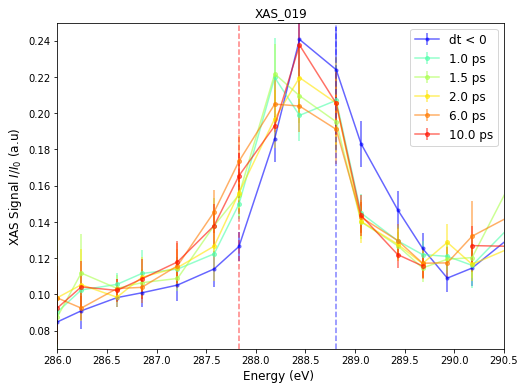

In [153]:
cop

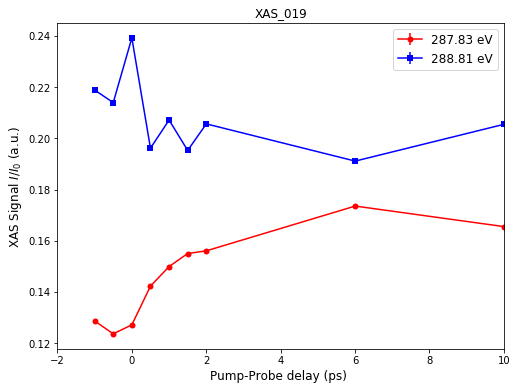

In [12]:
x1, x2 = [7,10]


### Plot delay traces

plt.figure(figsize=[8,6])

#plt.plot(times,XAS_spectrum[x1],'ro-', label='%.2f eV'%energies_sorted[x1],markeredgewidth=0.0)
#plt.plot(times,XAS_spectrum[x2],'bs-', label='%.2f eV'%energies_sorted[x2],markeredgewidth=0.0)

plt.errorbar(times,XAS_spectrum[x1],yerr=XAS_error[x1],fmt='ro-',label='%.2f eV'%energies_sorted[x1],markeredgewidth=0.0)
plt.errorbar(times,XAS_spectrum[x2],yerr=XAS_error[x2],fmt='bs-',label='%.2f eV'%energies_sorted[x2],markeredgewidth=0.0)


plt.legend(frameon=True,loc=0, prop={'size': 12})
plt.ylabel(r'XAS Signal $I/I_0$ (a.u.) ',size=12)
plt.xlabel(r'Pump-Probe delay (ps) ',size=12)
plt.xlim([-2, 10])
#plt.ylim([0.05, 0.07])
plt.title('XAS_0'+str(run))

plt.savefig(base_path + '/results/XAS_%03d_shortDelays.png'%run,dpi=300)

if runs[0] in [24, 28, 37, 38, 39, 40, 41]:
    plt.xlim([-2, 300])   
    plt.savefig(base_path + '/results/XAS_%03d_longDelays.png'%run,dpi=300)

if runs[0] in [24, 28, 37, 38, 39, 40, 41]:
    plt.xlim([-2, 50])   
    plt.savefig(base_path + '/results/XAS_%03d_medDelays.png'%run,dpi=300)
    
plt.show()



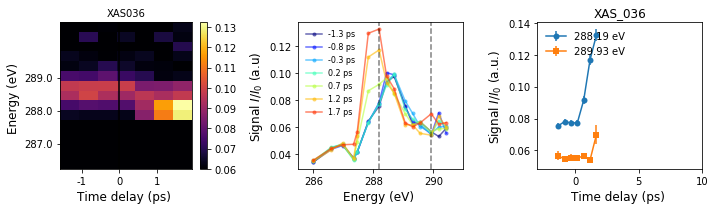

In [130]:
if run == 37 or run == 38 or run == 39 or run == 40:
    x1,x2 = 0,0 # energies to plot the pump-probe time series
    plt_spec = False
elif run == 36:
    x1,x2 = 6,12 # energies to plot the pump-probe time series
    plt_spec = True  
elif run == 21:
    x1,x2 = 7,14 # energies to plot the pump-probe time series
    plt_spec = True
else :
    x1,x2 = 0,1 # energies to plot the pump-probe time series
    plt_spec = True

    
    
plt.figure(figsize=[10,3])

# -- fig 1
plt.subplot(1,3,1)

if plt_spec:
    plt.imshow(XAS_spectrum,aspect='auto',interpolation='None',origin='lower',cmap='inferno',vmin=0.06)

    fE = interpolate.interp1d(energies_sorted,np.arange(n_energies))
    #E_ticks =np.arange(286,290)
    E_ticks =np.arange(np.floor(np.min(energies_sorted))+1,np.floor(np.max(energies_sorted)))
    y_ticks = fE(E_ticks)

    ft = interpolate.interp1d(times,np.arange(n_times))
    t_ticks =np.array([-1,0,1])
    x_ticks = ft(t_ticks)
    plt.yticks(y_ticks,E_ticks)
    plt.xticks(x_ticks,t_ticks)
    plt.title('XAS%03d'%run,size=10)
    plt.axvline(x=x_ticks[t_ticks==0],c='black')
    plt.colorbar()
    plt.xlabel(r'Time delay (ps) ',size=12)
    plt.ylabel(r'Energy (eV) ',size=12)

# -- fig 2

plt.subplot(1,3,2)

if plt_spec:
    #for i in [0,1,2,3,4,5,6,7,8] : # neg delays R24+27
    # for i in [0,1,2] : # neg delays R19 and R21
    for i in range(n_times) :
        color_index = float(i)/(len(delays))
        color = plt.cm.jet(color_index)
        plt.plot(energies_sorted,XAS_spectrum[:,i],'-o',color=color,ms=4, 
                 alpha=0.6,markeredgewidth=0.0,label='%.1f ps'%times[i])
    plt.axvline(x=energies_sorted[x1],ls='--',c='black',alpha=0.5)
    plt.axvline(x=energies_sorted[x2],ls='--',c='black',alpha=0.5)
    plt.legend(frameon=False,loc='upper left', prop={'size': 8})
    plt.ylabel(r'Signal $I/I_0$ (a.u) ',size=12)
    plt.xlabel(r'Energy (eV) ',size=12)
    plt.xlim(285.5,291)
    #plt.ylim(0.02,0.2)


# -- fig 3
plt.subplot(1,3,3)
plt.errorbar(times,XAS_spectrum[x1],yerr=XAS_error[x1],fmt='o-',
             label='%.2f eV'%energies_sorted[x1],markeredgewidth=0.0)
#plt.xscale('log')

#plt.errorbar(times,XAS_spectrum[x1],yerr=None,fmt='o-',
#             label='%.2f eV'%energies_sorted[x1],markeredgewidth=0.0)

if plt_spec:
    plt.errorbar(times,XAS_spectrum[x2],yerr=XAS_error[x2],fmt='s-',
                 label='%.2f eV'%energies_sorted[x2],markeredgewidth=0.0)

plt.legend(frameon=False,loc='upper left', prop={'size': 10})
plt.ylabel(r'Signal $I/I_0$ (a.u.) ',size=12)
plt.xlabel(r'Time delay (ps) ',size=12)
plt.tight_layout()
plt.xlim([-3, 10])
#plt.ylim([0.05, 0.07])
plt.savefig(base_path + '/results/XAS_%03d.png'%run,dpi=300)

plt.title('XAS_0'+str(run))


plt.show()